### Libraries

In [ ]:
#for colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/AppliedDeepLearning')

In [68]:
import torch
import pandas as pd
# import torchvision
import numpy as np
%matplotlib inline
import skimage.io as io
import matplotlib.pyplot as plt
import csv
from tqdm.auto import tqdm
import loader
import torch.nn as nn

from loader import FlickrDataset,preprocessing_transforms,get_data_loader,denormalize
from vocab import Vocabulary
from model import EncoderCNN,DecoderRNN,Attention
from torch.nn.utils.rnn import pack_padded_sequence
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import sys
del sys.modules["model"]

In [ ]:
pwd

'/content'

### Building Vocabulary and Loading our data


In [ ]:
vocab = Vocabulary(captions_file = './drive/MyDrive/AppliedDeepLearning/flickr30k_processed/train.csv',vocab_file = './drive/MyDrive/AppliedDeepLearning/vocab.txt')

In [ ]:
# vocab.build_vocab()

In [ ]:
# vocab.save_vocab()

In [ ]:
vocab.load_vocab()

In [ ]:
train_data = FlickrDataset('./drive/MyDrive/AppliedDeepLearning/flickr30k_processed/train.csv', vocab = vocab,images_folder='./drive/MyDrive/AppliedDeepLearning/flickr30k_processed/images', transform=preprocessing_transforms())

In [ ]:
val_data = FlickrDataset('./drive/MyDrive/AppliedDeepLearning/flickr30k_processed/val.csv', vocab = vocab,images_folder='./drive/MyDrive/AppliedDeepLearning/flickr30k_processed/images', transform=preprocessing_transforms())

In [ ]:
train_loader = get_data_loader(train_data, batch_size = 32,pad_index=0)

In [ ]:
val_loader = get_data_loader(val_data, batch_size = 32,pad_index=0)

In [ ]:
#looking at first 5 images & captions
i= 0
x, y,l = next(iter(train_loader))


10


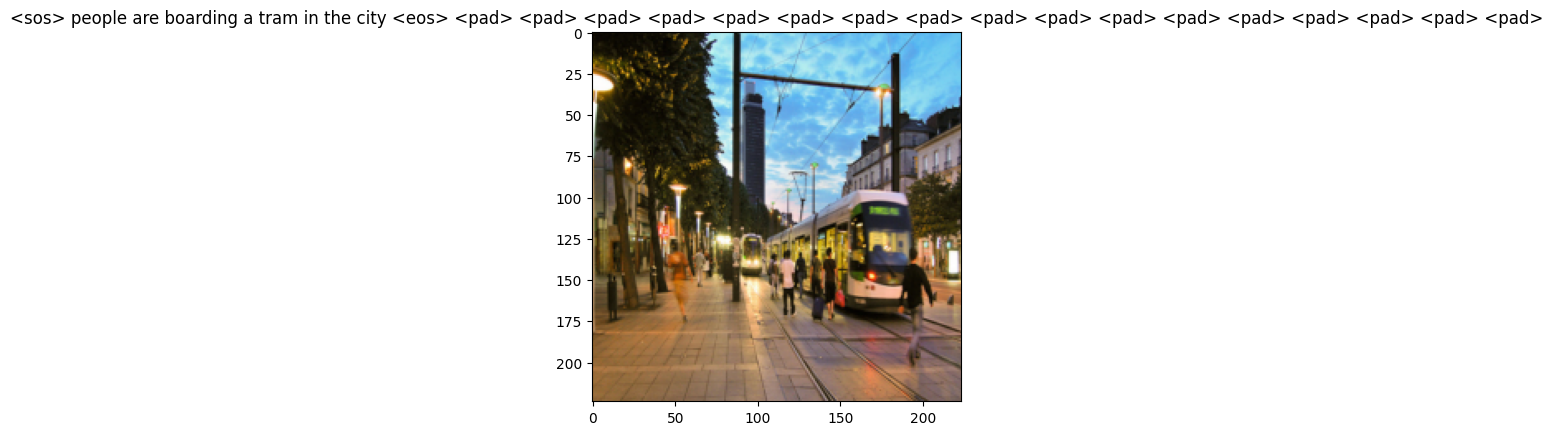

14


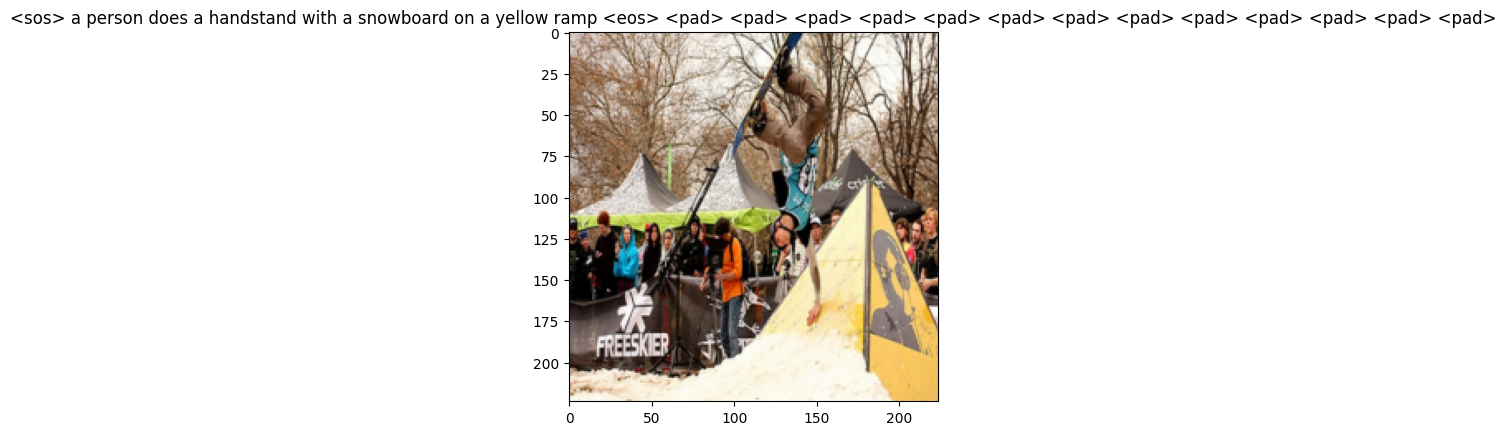

8


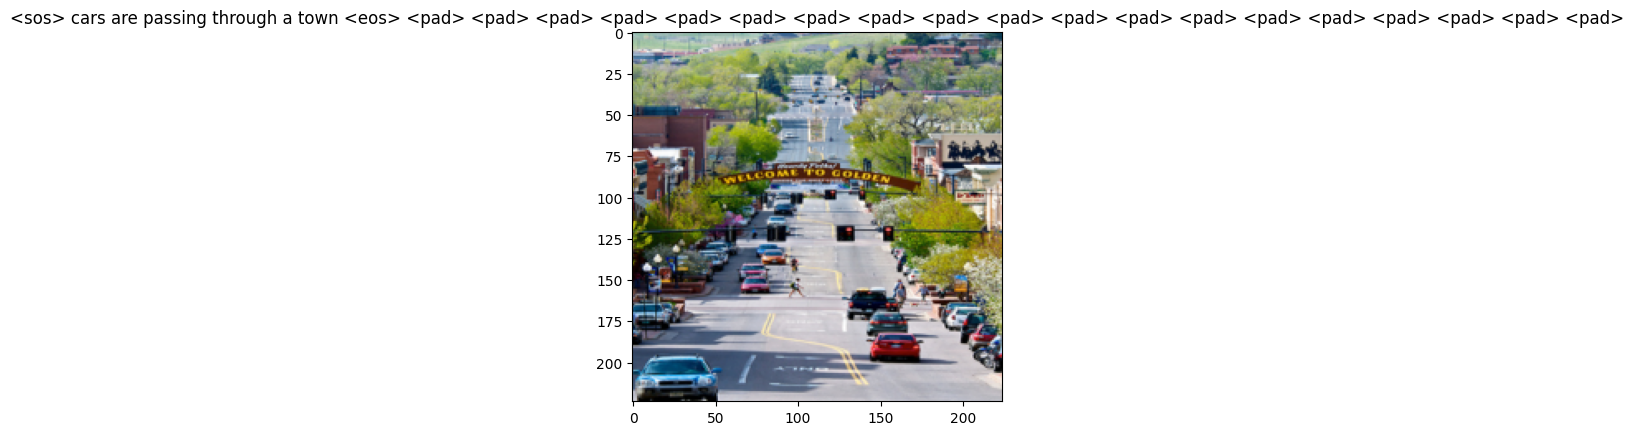

11


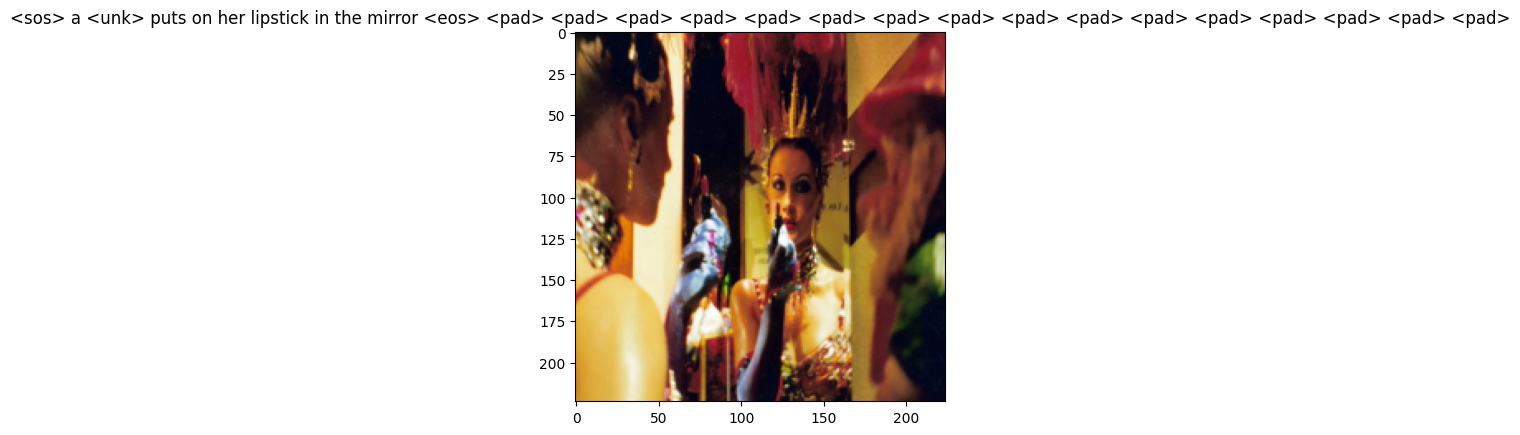

17


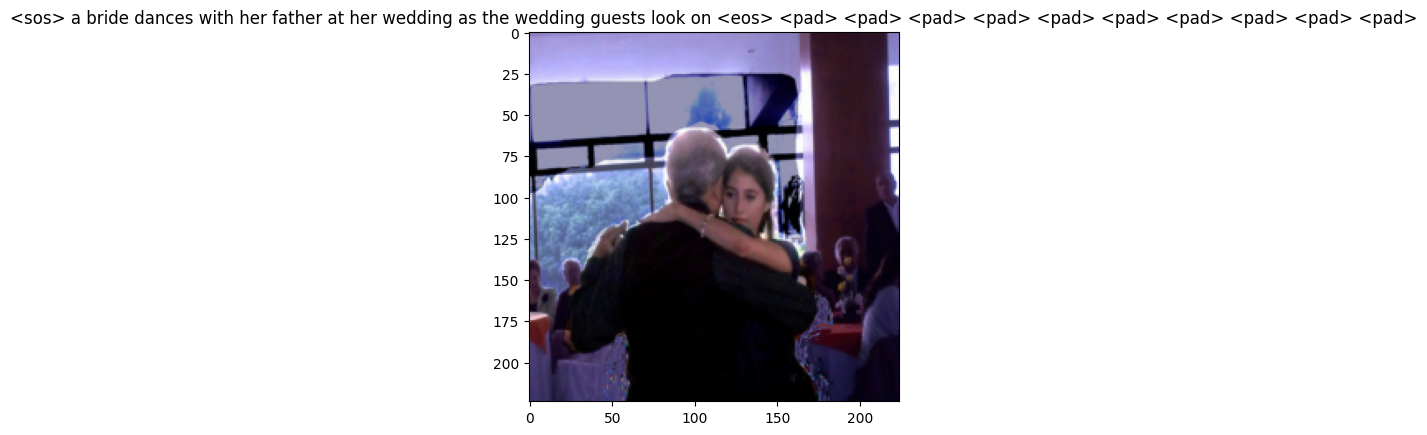

In [ ]:
#looking at first 5 images & captions
i= 0
x, y,l = next(iter(train_loader))
for image, caption,length in zip(x, y,l):
    image = denormalize(image)
    caption = [vocab.idx_to_word(int(word_id)) for word_id in caption]
    caption = ' '.join(word for word in caption)
    plt.imshow(image)
    plt.title(caption)
    print(length)
    plt.show()
    plt.pause(1)
    i+=1
    if i ==5:
        break

### Model

In [ ]:
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [ ]:
def save_checkpoint(epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):

    state = {
        'epoch': epoch,
        'epochs_since_improvement': epochs_since_improvement,
        'bleu-4': bleu4,
        'encoder': encoder,
        'decoder': decoder,
        'encoder_optimizer': encoder_optimizer,
        'decoder_optimizer': decoder_optimizer
    }
    filename = 'image_captioning_checkpoint_' + str(epoch) + '.pth'
    torch.save(state, filename)
    # store the copy of best checkpoint
    if is_best:
        print('Saving the best model')
        torch.save(state, 'image_captioning_best.pth')

In [80]:
def train(train_loader,encoder, decoder, criterion, encoder_optimizer,decoder_optimizer):
    losses = []
    decoder.train()
    encoder.train()

    for i, (imgs,caps,cap_lens) in enumerate(tqdm(train_loader),len(train_loader)):
      imgs = imgs.to(device)
      caps = caps.to(device)
      cap_lens = cap_lens.to(device)

      imgs = encoder(imgs)
      scores, caps_sorted, decode_lengths, alphas =  decoder(imgs, caps, cap_lens)

      #from <start> to <end>
      targets = caps_sorted[:,1:]

      scores = pack_padded_sequence(scores, decode_lengths, batch_first=True,enforce_sorted=False).data
      targets = pack_padded_sequence(targets, decode_lengths, batch_first=True,enforce_sorted=False).data

      loss = criterion(scores,targets) + alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
      print('s',scores)
      print('t',targets)
      #backpropagation
      decoder_optimizer.zero_grad()
      if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
      loss.backward()

      if grad_clip is not None:
          clip_gradient(decoder_optimizer,grad_clip)
          if encoder_optimizer is not None:
            clip_gradient(encoder_optimizer,grad_clip)

      decoder_optimizer.step()
      if encoder_optimizer is not None:
            encoder_optimizer.step()
      print(loss.item())
      losses.append(loss.item())

    return np.mean(losses)




In [81]:
def validate(val_loader,encoder, decoder, criterion):
    losses = []
    decoder.eval()
    encoder.eval()


    references = list()  # true captions
    hypotheses = list()  # predicted captions

    with torch.no_grad():
      for i, (imgs,caps,cap_lens) in enumerate(tqdm(val_loader, len(val_loader))):
        imgs = imgs.to(device)
        caps = caps.to(device)
        cap_lens = cap_lens.to(device)

        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas = decoder(imgs, caps, cap_lens)

        targets = caps_sorted[:, 1:]

        scores_copy = scores.clone()
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True,enforce_sorted=False).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True,enforce_sorted=False).data


        loss = criterion(scores, targets) + alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        losses.append(loss.item())

        references = targets

        _, preds = torch.max(scores_copy, dim=2)
        preds = preds.tolist()
        temp_preds = list()
        for j, pred in enumerate(preds):
            temp_preds.append(preds[j][:decode_lengths[j]])
        hypotheses.extend(temp_preds)

        assert len(references) == len(hypotheses)
        print(references, hypotheses)
        bleu4 = corpus_bleu(references, hypotheses)
    return np.mean(losses), bleu4

In [82]:
embed_dim = 512      # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512    # dimension of decoder RNN
encoder_dim = 2048
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
vocab_size = 50000
best_bleu4 = 0.
lr_decay_factor = 0.8
lr_decay_patience = 8
best_bleu4 = 0
patience = 4

num_epochs = 20
epochs_since_improvement = 0

fine_tune_encoder = False

decoder = DecoderRNN(attention_dim,embed_dim,decoder_dim, vocab_size, encoder_dim)
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()), lr=decoder_lr)

encoder = EncoderCNN()
encoder.fine_tune(fine_tune_encoder)
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()), lr=encoder_lr) if fine_tune_encoder else None


encoder = encoder.to(device)
decoder = decoder.to(device)

encoder_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, mode='max', factor=lr_decay_factor, patience=lr_decay_patience) if fine_tune_encoder else None
decoder_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, mode='max', factor=lr_decay_factor, patience=lr_decay_patience)
criterion = nn.CrossEntropyLoss().to(device)


for epoch in range(1,num_epochs+1):
  loss_train = train(train_loader,encoder,decoder,criterion, encoder_optimizer, decoder_optimizer)
  loss_val, bleu4_val = validate(val_loader, encoder, decoder, criterion)

  decoder_lr_scheduler.step(bleu4_val)
  if fine_tune_encoder:
          encoder_lr_scheduler.step(bleu4_val)

  is_best = bleu4_val > best_bleu4
  if bleu4_val > best_bleu4:
    best_bleu4 = bleu4_val
    patience = 4

  else :
    patience -=1


  if patience <= 0:
    print('Triggering early stopping')
    break

  print('-' * 40)
  print(f'epoch: {epoch}, train loss: {loss_train:.4f}, valid loss: {loss_val:.4f}, best BLEU-4: {best_bleu4:.4f}')
  print('-' * 40)

  save_checkpoint(epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                    decoder_optimizer, bleu4_val, is_best)

















/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/4532 [00:00<?, ?it/s]

s tensor([[ 0.0554,  0.0061, -0.0083,  ...,  0.2318,  0.0055, -0.0278],
        [-0.0283,  0.2405,  0.0569,  ..., -0.0502, -0.2390,  0.0263],
        [ 0.0488, -0.1042, -0.1240,  ..., -0.0724,  0.0296, -0.1340],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0', grad_fn=<PackPaddedSequenceBackward0>)
t tensor([   5,   14,    4,    4,    4,  224,    4,    4,   14,   14,    4,    4,
          17,    4,  173,    4,    4,  261,   58,  182,    6,    4,  112,    4,
           4,    4,   14,    4,   43,   21,    3, 1846,    4,   21,   58,    9,
         897,    9, 1561,  147,  202,   30,   37,   55,   15, 4359,   29,  917,
           9,  182,    5,  215,  198,    9,  413,   13,   13,  636,   61,  811,
          58,   31,  373,    5,    3,   61,   20,  259,   31,   10,   20,  961,
          33,   15,

KeyboardInterrupt: ignored

In [78]:
loss_train

NameError: ignored

In [ ]:
encoder = EncoderCNN(embed_size=512,device = device).to(device)

In [ ]:
decoder = DecoderRNN(embed_size = 512, hidden_size =1024,vocab_size =  5000,num_layers=1,max_seq_length=20,device = device).to(device)


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
parameters = list(decoder.parameters())  + list(encoder.linear.parameters()) + list(encoder.bn.parameters())

In [ ]:
# decoder = DecoderRNN(image_emb_dim = 512,word_emb_dim=512,hidden_dim= 1024,num_layers= 1,vocab_size=5000,device =device).to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()


In [ ]:
parameters = list(decoder.parameters())  + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params=parameters, lr= 0.001)

### Training my model

In [ ]:
epochs = 3
from torch.nn.utils.rnn import pack_padded_sequence


In [ ]:
from nltk.translate.bleu_score import corpus_bleu


In [ ]:
encoder_model = '/content/drive/MyDrive/AppliedDeepLearning/encoder.sav'
decoder_model = '/content/drive/MyDrive/AppliedDeepLearning/decoder.sav'

In [65]:
best_bleu4 = -100
no_improvement = 0
patience = 3
early_stopper = False
for epoch in range(3):
    train_loss = []
    val_loss = []
    predictions = []
    references = []

    for images,captions,lengths in tqdm(train_loader):
        encoder.train()
        decoder.train()
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True,enforce_sorted=False)[0]

        #forward, backward and optimization
        features = encoder(images)
        outputs = decoder(features,captions,lengths)
        t_loss = criterion(outputs,targets)

        t_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(t_loss.item())


    with torch.no_grad():
        for images,captions,lengths in tqdm(val_loader):
            encoder.eval()
            decoder.eval()

            images = images.to(device)
            captions = captions.to(device)
            lengths = lengths.to(device)
            features = encoder(image)
            targets = pack_padded_sequence(captions, lengths, batch_first=True,enforce_sorted=False)[0]
            decoder(features,captions,lengths)
            v_loss = criterion(outputs,targets)

            hypotheses_ids = decoder.sample(features)
            hypotheses_ids = hypotheses_ids[0].cpu().numpy()


            # Convert word_ids to words
            sampled_caption = []
            for word_id in hypotheses_ids:
                word = vocab.idx_to_word[word_id]
                sampled_caption.append(word)
                if word == '<end>':
                    break
            sentence = ' '.join(sampled_caption)

            val_loss.append(v_loss)
            predictions.append(predictions)
            references.append(targets)

    bleu4 = corpus_bleu(references, predictions)
    print(f'Epoch {epoch +1} Train Loss : {np.mean(train_loss)} ')
    print(f'Epoch {epoch +1} Validation Loss : {np.mean(val_loss)} , BLEU Score {bleu4} ')

    if bleu4 > best_bleu4:
        torch.save(encoder.state_dict(), encoder_model)
        torch.save(decoder.state_dict(),decoder_model)
        best_bleu4 = bleu4
        no_improvement = 0
    else:
        no_improvement +=1

    if no_improvement >= patience:
        early_stopper = True
        print(f'Triggering early stopping at epoch {epoch+1}')
        break







  0%|          | 0/4532 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
device

device(type='cuda')

In [ ]:
s = []
for i in 'I am here':
  s.append(vocab.word_to_idx(i))

In [ ]:
l = []
for i in s:
  l.append(vocab.idx_to_word(i))

In [ ]:
l

['<unk>', '<unk>', 'a', 'm', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']